# Project 6: 3D Pose Estimation and Objectron for object detection

## Brief
- Deliverables:
    - Report: Dec 7th, 11:59 PM.
    - Code: Dec 7th, 11:59 PM.
- Hand-in: through Gradescope
- Sections:
    - Part 1: 3D bounding box detection on 2D images
    - Part 2: Estimation of world coordinates of the camera **(no coding required)**
    - Part 3: Human Pose Detection
    - Part 4: Projection of 2D pose estimation to 3D world coordinates **(no coding required)**
    - Part 5: Intersection between Pose and Objectron
    - Part 6: (All)Extra Credit: your own image
    - Part 7: (Grad) Extra Credit: intersection detection in a video
        

## Overview
The goal of this project is to let you experience working with state-of-the-art libraries and real-time processing of video. We will be working with [MediaPipe](https://google.github.io/mediapipe/), which offers customizable Machine Learning solutions for live media. Specifically, we will use: [pose estimation](https://google.github.io/mediapipe/solutions/pose), which estimates the pose of a person in real time; and [objectron](https://google.github.io/mediapipe/solutions/objectron.html), which is a 3D object detector from 2D images. We will try to identify an object that is being touched by a person with these tools.

## Imports

In [2]:
%reload_ext autoreload
%autoreload 2

import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import cv2

from proj6_unit_tests import test_base
from proj6_unit_tests import test_my_objectron
from proj6_unit_tests import test_pose_estimate
from proj6_unit_tests import test_intersection
from proj6_unit_tests import test_utils
from proj6_code import student_code
from proj6_code import utils

## Part 1: 3D bounding box detection on 2D images

We're going to use mediapipe's [objectron](https://google.github.io/mediapipe/solutions/objectron) library based on this [paper](https://arxiv.org/pdf/2003.03522.pdf) to detect 3D bounding boxes of chairs in images. An example is shown in the figure below.

<img src="https://google.github.io/mediapipe/images/mobile/objectron_chair_android_gpu.gif" width="150"/>
<center>3D Objectron example.</center>

Basically, there is an encoder and a decoder for the detection part. The encoder takes an image as input, analyzes it, and gives some useful information in a certain form. Then the decoder takes these intermediate information as input, translates them into things we want (i.e., 8 vertices' 2D coordinates).
The encoder is trained as a neural network, whose weight file is provided and can be read by Tensorflow (which is the `inference()` function in `my_objectron.py`). The decoder part is implemented as the `decode()` function in `my_objectron.py`. **You should read the paper and figure out what is the intermediate information to finish the coding work, otherwise you will not understand how to write the code for this section or answer the report reflection questions.**

Most of the code is already implemented for you based on [this](https://github.com/yas-sim/objectron-3d-object-detection-openvino) Github repo.

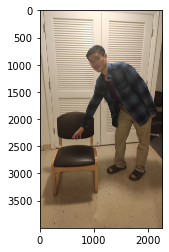

In [53]:
# Reading test image
#student_test_img='../data/10.jpg'
#student_test_img='../data/before.jpg'
student_test_img='../data/after.jpg'
img = cv2.imread(student_test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

**TODO 1**:  finish `detect_3d_box()` in `student_code.py`, then run the following cell.

0.954166829586029


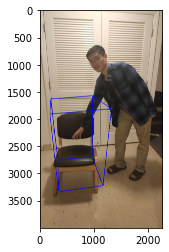

In [54]:
bounding_boxes_chair_2d, annotated_img = student_code.detect_3d_box(student_test_img)
plt.imshow(annotated_img)
plt.show()

In [55]:
print("Testing your objectron detection: ", test_base.verify(test_my_objectron.test_my_objectron))

0.9799638986587524
Testing your objectron detection:  "Correct"


## Part 2: Estimation of world coordinates of the camera

### 2.1 Establish the world coordinate frame

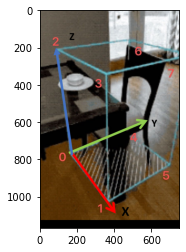

In [56]:
# Read test image
img_index = cv2.imread('../data/world_frame.png')
img_index = cv2.cvtColor(img_index, cv2.COLOR_BGR2RGB)
plt.imshow(img_index)
plt.show()

Similar to project 5, we want to estimate the intrinsic camera matrix, but this time we will provide an initial estimation for a cube, giving 8 vertices in 3D coordinate. In this coordinate system, we define 0 as the `origin`, 0-1 as the `x-axis`, 0-4 as the `y-axis`, and 0-2 as the `x-axis`.

Then, we need to estimate the dimensions of the chair to calculate the location of the coordinates in the world frame.

**NOTE**: This part has already been implemented for you in `get_world_vertices()` in `utils.py`, feel free to check it out.

In [58]:
# You need to measure the size of chair at first, and set their values there. 
# For example, the example chair's size is 0.4m * 0.4m *1.0m
size_x = 0.8
size_y = 0.8
size_z = 1.0
vertices_world = student_code.get_world_vertices(size_x, size_y, size_z)
print(vertices_world)
initial_box_points_3d = vertices_world
print("Testing your get_world_vertices: ", test_base.verify(test_utils.test_get_world_vertices))

[[0.  0.  0. ]
 [0.8 0.  0. ]
 [0.  0.  1. ]
 [0.8 0.  1. ]
 [0.  0.8 0. ]
 [0.8 0.8 0. ]
 [0.  0.8 1. ]
 [0.8 0.8 1. ]]
Testing your get_world_vertices:  "Correct"


### 2.2 Estimate intrinsic matrix of your camera

Different from project 5, we can use a convenient function from [OpenCV](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a) to help calibrate our camera, by taking pictures of a chessboard from various angles (better > 10). You can refer to the pictures in the *../data/cali2/example* folder.

If you want to experiment with your own camera/images, feel free to play around with the `Checkerboard-A4-35mm-7x4.pdf` in the `data` folder. There are also two video demoes about how to do camera calibration: [Example1-Camera Calibration](https://www.youtube.com/watch?v=HNfPbw-1e_w), this is for explaining the checkerboard, but you don't need to measure the length of grid on the checkboard. [Example2-Camera Calibration](https://www.youtube.com/watch?v=v7jutAmWJVQ), you need to take pictures as 1:30-1:50 in the video, you can either move the checkboard like in the video or move your camera.

The `calibrate()` function in `utils.py` requires the number of grids. If you use the checkerboard provided in the `data` folder, you can simply use the default parameters. If you want to try your own checkerboard, please note that the part used for calibration is two subgrids smaller than the actual in both x and y direction. For example, the example picture, the checkerboard has 5 x 8 subgrids, then the part used for calibration should be 3 x 6, thus the number of vertices should be 4 x 7 (corresponding to m and n in `calibrate` function).

If you are interested in what is the mechanism in calibrating a camera with checkerboard, you can refer to [WiKi- Camera Calibration](https://en.wikipedia.org/wiki/Chessboard_detection#:~:text=Chessboard%20camera%20calibration,-A%20classical%20problem&text=Chessboards%20are%20often%20used%20during,interest%20points%20in%20an%20image.) and [OpenCV Doc](https://docs.opencv.org/3.4/d4/d94/tutorial_camera_calibration.html)

Important tips:
- Take pictures from different angles, and avoid very similar pictures
- Use the pictures of the same resolution for all the tasks; Usually, phone camera uses different zoom for taking pictures and record videos. 
- By default, phone cameras usually adjust focal length automatically. You need to find a way to fix that.

**NOTE**: `calibrate()` is implemented for you in `utils.py`, feel free to check it out.

In [59]:
from proj6_code.utils import calibrate

path2 = '../data/cali2/example2/' # update the path to where you save the pictures
m = 5 # m is the vertice number in x direction
n = 7 # n is the vertice number in y direction

K = calibrate(path2)

../data/cali2/example2/*.jpg
[[1.11573975e+03 0.00000000e+00 7.22275004e+02]
 [0.00000000e+00 1.06794751e+03 5.31184727e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### 2.3 Estimate camera pose

After you get the 8 vertices of the box in 2D coordinate and the camera intrinsic matrix, we can recover the projection matrix by method called perspective-n-point method. Perspective-n-Point is a typical problem in 3D geometry estimating the pose of a calibrated camera given `n` 3D points in world and their corresponding 2D projected points on image frame. There are several way to get the projection matrix given the 2D-3D correspondence.

* **Direct Linear Transform (DLT)**, we use this method in project 5 to solve the projection matrix. Remember in previous project, we mentioned P has 11 DoF, thus we need at least 6 correspondencse to get the P. But this method has limitation on accuracy because it uses SVD to solve the P as a 12x1 vector ignoring the inner connection of all 12 parameters.

* **Perspective-3-Point (P3P)**, is the minimal form of PnP problem. This method uses the law of cosines to give extra constraints of the 6 triangles (3 similar triagle pairs) formed by the 3 correspondence and camera center. This method has disadvantages of limitation on information given only by three correspondence. Besides, when there are noises in the three correspondence, it is not robust.

* **Perspective-n-Point (PnP)**, is a often used pose estimation method which is more robust. Use the projection model, we can define the reprojection error, which is the difference between the projected 3D points and their matched 2D points, here the intrinsic matrix K should be known. Then given an initial estimation of camera pose, you can solve the problem by using nonlinear optimization. Give some perturbation to the intial estimation and then calculate the jacobian and hessian matrix, then you can get a update on your intial estimation. Repeat the process untill the error converges, you will get a well optimized camera pose. You can also refer to the [Wiki-Perspective-n-Point](https://en.wikipedia.org/wiki/Perspective-n-Point) to know more.

**Note:** The rotation and translation returned by cv2.solvePnP is different with what we deal with in project4. In project4, we use the notations below:

- ${}^wR_c$: for rotation of the camera in the world coordinate frame
- ${}^wt_c$: for translation of the camera in the world coordinate frame, which is the **camera_center**
- ${}^cR_w$: ${}^cR_w = {{}^wR_c}^T$

In project 5, The projection matrix **P**

\begin{align}
\mathbf
{P}=  \mathbf{K} \: {}^w \mathbf{R}_c^\top [ \mathbf{I}\;|\; -{}^w \mathbf{t}_c ] =
\begin{bmatrix}
    \alpha & s & u_0 \\
    0 & \beta & v_0 \\
    0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
r_{11} & r_{21} & r_{31} \\
r_{12} & r_{22} & r_{32} \\
r_{13} & r_{23} & r_{33}
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & -t_x \\
0 & 1 & 0 & -t_y \\
0 & 0 & 1 & -t_z
\end{bmatrix}
\end{align}

And this transform from world coordinate to camera coordinate:

$$\begin{bmatrix}X_c\\Y_c\\Z_c\\1\end{bmatrix} = \begin{bmatrix}\mathbf{{}^wR_c^T} & -\mathbf{{}^wR_c^T}\ {}_w\mathbf{t}_c\\0^\top  & 1\\\end{bmatrix}\begin{bmatrix}X_w\\Y_w\\Z_w\\1\end{bmatrix}$$

**In opencv**, The translation $tvec$ and rotation part $rvec$ returned by `cv2.solvePnP()` is 

\begin{align}
tvec = \begin{bmatrix} t_1 & t_2 & t_3 \end{bmatrix} ^T
\end{align}

\begin{align}
\begin{bmatrix}
r_{11} & r_{21} & r_{31} \\
r_{12} & r_{22} & r_{32} \\
r_{13} & r_{23} & r_{33}
\end{bmatrix} = Rodrigues Transform (rvec)
\end{align}

Another form to perform the transformation from world coordinate to camera coordinate is use the ${}^c{T}_w$ matrix,

$$\begin{bmatrix}X_c\\Y_c\\Z_c\\1\end{bmatrix} = {}^c{T}_w \begin{bmatrix}X_w\\Y_w\\Z_w\\1\end{bmatrix}$$

\begin{align}
\mathbf
{}^c{T}_w=
\begin{bmatrix}
r_{11} & r_{21} & r_{31} & t_1 \\
r_{12} & r_{22} & r_{32} & t_2 \\
r_{13} & r_{23} & r_{33} & t_3 \\
0 & 0 & 0 & 1
\end{bmatrix} = \begin{bmatrix}\mathbf{{}^wR_c^T} & -\mathbf{{}^wR_c^T}\ {}^w\mathbf{t}_c\\0^\top  & 1\\\end{bmatrix}
\end{align}

Therefore, to get the ${}^wR_c$, projection matrix $\textbf{P}$ and camera center ${}^wt_c$ from `tvec` and `rvec`, you need to transform it by:

$$ {{}^wR_c}^T = Rodrigues Transform (rvec) $$

$$ P = K * \begin{bmatrix} {{}^wR_c}^T & tvec \end{bmatrix} $$

$$ {}^wt_c = - {{}^wR_c} * tvec $$

In this project, you do not need to implement the PnP method yourself, you can call the function from `cv2.solvePnP`. After you get the tvec and rvec from cv2.solvePnP, you need to return the ${}^w \mathbf{R}_c^\top$, the camera center in world coordinate and the projection matrix $\textbf{P}$.


**NOTE**: `perspective_n_points()` is implemented for you in `utils.py`, feel free to check it out.

In [60]:
from proj6_code.utils import perspective_n_points

bounding_boxes = bounding_boxes_chair_2d
height = annotated_img.shape[0]
width = annotated_img.shape[1]

box_points_2d = np.array(bounding_boxes)
box_points_2d[:, 0] *= width
box_points_2d[:, 1] *= height

wRc_T, camera_center, P = perspective_n_points(initial_box_points_3d, box_points_2d, K)

Then you can visualize the world coordinate of the box object and camera pose to **check whether the results gotten by the PnP method** and **your P, ${}^wt_c$** is correct.

The camera center is at: 
 [[0.76228848]
 [3.31443509]
 [1.40238505]]


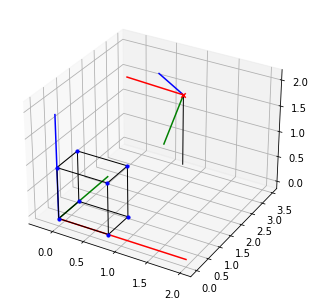

In [61]:
from proj6_code.utils import plot_box_and_camera
plot_box_and_camera(initial_box_points_3d, camera_center, wRc_T.T)

## Part 3: Human Pose Estimation
In this part, you will use [mediapipe](https://google.github.io/mediapipe/) to do pose estimate from videos. As an important task of computer vision, human Pose Estimation is defined as the problem of localization of human joints (also known as keypoints - elbows, wrists, etc) in images or videos. It has great application in many real-life situations, such as action recognition, AR/VR, animation, gaming, etc.

The official [document](https://google.github.io/mediapipe/solutions/pose#overview) on pose estimation also provides some more detailed explanation, examples, and tutorial about how to use the python version of pose estimation can be found [there](https://google.github.io/mediapipe/solutions/pose#python).


### Detect human pose from images

**TO-DO 2**:  finish `hand_pose_img()` in `student_code.py`


<img src="https://google.github.io/mediapipe/images/mobile/pose_tracking_android_gpu_small.gif" width="150"/>
<center>Pose detection example.</center>

Detected landmark numbers:  33


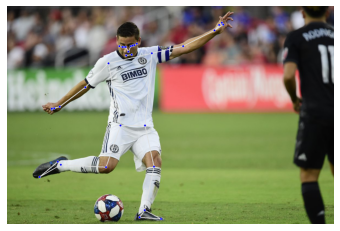

In [62]:
player_test_img='../data/player1.jpg'

player_land_mark, annotated_image = student_code.hand_pose_img(player_test_img)
print('Detected landmark numbers: ', len(player_land_mark))
utils.imshow1(annotated_image)

In [63]:
# Although you may say this is actually the right toe physically, 
# we can call it left toe for now in this notebook, to be consistent with 
# the name convention used in mediapipe's pose estimation.

left_toe = player_land_mark[32]
print(left_toe)

[119.43694353 627.38676071]


In [64]:
print("Testing your pose estimation: ", test_base.verify(test_pose_estimate.test_pose_estimate))


Testing your pose estimation:  "Correct"


## Part 4: Projection of 2D pose estimation to 3D world coordinates
In this section, you're going to project the 2D human pose estimation onto the 3D coordinates in the world frame (or to be more specific, the chair-center frame). (to do this we will have to tell how far the person is from the camera)

The projection function is pretty similar to the one you implement in project 5, except that we project from 2D to 3D instead of 3D to 2D. We use camera matrix $P \in R^{3×4}$ as a projective mapping from world (3D) to pixel (2D) coordinates defined up to a scale.

\begin{align}
z\begin{bmatrix}
x_p\\
y_p\\
1
\end{bmatrix}
=
\mathbf
{P}
\begin{bmatrix}
x_w\\
y_w\\
z_w\\
1
\end{bmatrix}
\end{align}

The camera matrix can also be decomposed into intrinsic parameters K and extrinsic parameters ${}^w \mathbf{R}_c, \: {}^w \mathbf{t}_c$.

$\mathbf{P} = \mathbf{K} \: {}^w \mathbf{R}_c^\top [\mathbf{I}\;|\; -{}^w \mathbf{t}_c].$

\begin{align}
\mathbf
{P}=
\begin{bmatrix}
    \alpha & s & u_0 \\
    0 & \beta & v_0 \\
    0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
r_{11} & r_{21} & r_{31} \\
r_{12} & r_{22} & r_{32} \\
r_{13} & r_{23} & r_{33}
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & -t_x \\
0 & 1 & 0 & -t_y \\
0 & 0 & 1 & -t_z
\end{bmatrix}
\end{align}

Generally, we cannot fully recover the 3D coordinates from a 2D feature points because the depth information is lost. As such, you're asked to provide the depth information (i.e., $z$ in the projection equation above.) The physical meaning of depth is the physical distance between human in the picture and the camera in meters. In the test files, the depth information used is provided. In the next sections, you need to measure the depth information on your own to make your customized videos work.


**NOTE**: `projection_2d_to_3d()` is implemented for you in `utils.py`, feel free to check it out.

To make things clear, in this project, you have to work with three coordinate frames in total. The world frame (which is defined as the chair frame, 3D), the camera-centric frame (3D), and the image frame (2D). In this sectrion, you will project feature points in 2D image frame to the 3D chair frame.

In [65]:
P = K.dot(wRc_T.dot( np.hstack((np.eye(3),-1.0*camera_center)) ))

In [83]:
depth = 1.5

student_land_mark, _ = student_code.hand_pose_img(student_test_img)
pose3d_landmark = student_code.projection_2d_to_3d(P, depth, student_land_mark)

left_hand = pose3d_landmark[22]
print("Your 3D pose landmark of the left hand is ", left_hand)

print("Testing your 3d human pose estimate: ", test_base.verify(test_pose_estimate.test_projection_2d_to_3d))

Your 3D pose landmark of the left hand is  [0.32951049 0.70002384 0.59562086]
Testing your 3d human pose estimate:  "Correct"


In [84]:
# Test if you can project the 0 vertice back correctly
P.dot(np.array([0,0,0,1]).T)/P.dot(np.array([0,0,0,1]).T)[2]

array([9.17658913e+02, 2.59970065e+03, 1.00000000e+00])

## Part 5: Intersection between Pose and Objectron



After detecting both the 3D coordinates of human pose and the 3D coordinates of 8 vertices of the chair, we can now finally apply our trick now. We will detect whether the hand is in the bounding box of the chair in this section (And you can try to detect other parts too). If so, then we would change the color of the bounding box to show it. (Black if no detection, a bight color if detection) Such kind of detection would be pretty useful for situations like collision check and obstacles avoidance.


**TO-DO 3**: finish `check_hand_inside_bounding_box()` in `student_code.py`

In [85]:
print(vertices_world)
print(left_hand)

[[0.  0.  0. ]
 [0.8 0.  0. ]
 [0.  0.  1. ]
 [0.8 0.  1. ]
 [0.  0.8 0. ]
 [0.8 0.8 0. ]
 [0.  0.8 1. ]
 [0.8 0.8 1. ]]
[0.32951049 0.70002384 0.59562086]


Check succeed!


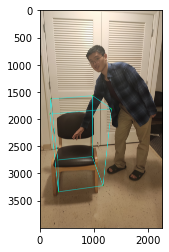

In [86]:
annotated_img = student_code.draw_box_intersection(img, left_hand, vertices_world, bounding_boxes_chair_2d)

plt.imshow(annotated_img)
plt.show()

In [37]:
print('Test for intersection checking:', test_base.verify(test_intersection.test_check_hand_inside_bounding_box))

Test for intersection checking: "Correct"


## (All) Extra Credit: Do it with your own image!

This project is specifically designed to make you interact with your own image and accumulate more real-world CV project experience. Therefore, you're encouraged to take your own pictures, do the calibration task on your own, run detection and estimation with your code. The result you get will be written in the report. To make things easier, we summarize several important tips for you:

(calibration is the heavy work here)

- Take pictures for both before (hand is far from chair) and after interaction, and show it in the report
- Use the same camera and focal length for both calibration pictures and interaction pictures
- Use the pictures of the same resolution for all the tasks; Usually, phone camera use different zoom for taking pictures and record videos. As such, in the extra credit part, you can consider making a video which combines both camera calibration and human pose interaction. After it, extracting frames of the calibration part and use these pictures for calibration.
- `Mediapipe` and `Objectron` do not work for all the situations. So, if you find some pictures do not work in the detection part, firstly, try to change the subject and pose, secondly, try to change the environment, lights, background, etc. You should still be able to find many working situations
- The detection may not be able to work very precisely, and so you're allowed to slightly change a few real-world parameters, such as the size of chair, the depth of pose (the real-world distance between the people in the picture and the camera)


## (Grad) Extra Credit: Intersection Detection in a Video

Congratulations! You just constructed a working pipeline for a single image. At this point, we would like to process a video and look into more than one object.
- Video processing: The video proessing logic is given to you. Try to understand the logic and feel free to refer to openCV's documentation for video processing related functions.
- Pipeline building: Fill out the code blanks with calls to existing functions in order to complete the pipeline. There are detailed steps given in the notebook for you to follow.
- Video submission: Include a link to your video output in your report, make sure the link is playable (Youtube or Google drive or other playable links). You could check the output video in the data/extra_credit_video folder.

This cell should take around eight minutes two complete.

In the report, you have to answer all the questions to receive full credit for extra credit part.

In [32]:
video_path = '../data/raw.mp4'
student_code.process_video(video_path)


start
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.965776264667511
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.963575541973114
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9672180414199829
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.964154839515686
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9637866020202637
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000

0.9547772407531738
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9547772407531738
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9574726819992065
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9613890647888184
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9653759002685547
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.963457465171814
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971

0.9705874919891357
Check succeed!
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9695874452590942
Check succeed!
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9693242311477661
Check succeed!
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9703130722045898
Check succeed!
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9707635641098022
Check succeed!
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.970

0.9636192917823792
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9668943881988525
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9637285470962524
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9634678959846497
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9634678959846497
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9640795588493347
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.1382297

0.9711272120475769
Check succeed!
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.971936047077179
Check succeed!
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9655792713165283
Check succeed!
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9683711528778076
Check succeed!
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9691751599311829
Check succeed!
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9711

0.9675564765930176
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9658679962158203
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9653536081314087
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9644601345062256
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9627354741096497
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9631439447402954
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.1382297

0.9609965085983276
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9609965085983276
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9616268873214722
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.961631178855896
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.962433397769928
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9631162881851196
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e

0.9612642526626587
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9614672660827637
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.95921790599823
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9565405249595642
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9573186635971069
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9569370746612549
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e

0.9662407636642456
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9644001722335815
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9652762413024902
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9662346839904785
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9656347036361694
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.13822971e+02]
 [0.00000000e+00 1.18801562e+03 5.82186193e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.9653924703598022
../data/cali3/*.jpg
[[1.16683850e+03 0.00000000e+00 3.1382297

## Code testing
We have provided a set of tests for you to evaluate your implementation. We have included tests inside ```proj6.ipynb``` so you can check your progress as you implement each section. At the end, you should call the tests from the terminal using the command ```pytest proj6_unit_tests/```

## Submission

This is very important as you will lose 5 points for every time you do not follow the instructions.

Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that's not in there by default will probably cause your code to break during grading. Do not use absolute paths in your code or your code will break. Use relative paths like the starter code already does. Failure to follow any of these instructions will lead to point deductions. Create the zip file using ```python zip_submission.py --gt_username <your_gt_username>``` (it will zip up the appropriate directories/files for you!) and hand it through Gradescope. Remember to submit your report as a PDF to Gradescope as well.

## Rubric
The overall rubric division for this part is:

| Submission Type | Credit Type | Individual |
| --------------- | ----------- | ---------- |
| Code            | Mandatory   | 30         |
| Report          | Mandatory   | 70         |
| Report          | EC          | 7          |
| Total           |             | 107        | 



## Credit

Assignment developed by Sen Wang, Jing Wu, Vijay Upadhya, Haoxin Ma, Sergio Aguilera and Frank Dellaert. Assignment modified in Fall 2021 by Junyan Mao, and Lixing Liu